# Create Word Context Embeddings

In [1]:
# import modules
import numpy as np
import pandas as pd
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.base import TransformerMixin
from sklearn.decomposition import FastICA, TruncatedSVD, PCA, NMF
from sklearn.preprocessing import StandardScaler
import re
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer

In [2]:
# to convert contractions picked up by word_tokenize() into full words
contractions = {
    "n't": 'not',
    "'ve": 'have',
    "'s": 'is', # note that this will include possessive nouns
    'gonna': 'going to',
    'gotta': 'got to',
    "'d": 'would',
    "'ll": 'will',
    "'re": 'are',
    "'m": 'am',
    'wanna': 'want to'
}

# to convert nltk_pos tags to wordnet-compatible PoS tags
def convert_pos_wordnet(tag):
    tag_abbr = tag[0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
                
    if tag_abbr in tag_dict:
        return tag_dict[tag_abbr]

In [3]:
class ContextMatrix(TransformerMixin):
    
    # initialize class & private variables
    def __init__(self,
                 window_size = 4,
                 remove_stopwords = True,
                 add_start_end_tokens = True,
                 lowercase = False,
                 lemmatize = False,
                 pmi = False,
                 spmi_k = 1,
                 laplace_smoothing = 0,
                 pmi_positive = False,
                 sppmi_k = 1):
        
        """ Params:
                window_size: size of +/- context window (default = 4)
                remove_stopwords: boolean, whether or not to remove NLTK English stopwords
                add_start_end_tokens: boolean, whether or not to append <START> and <END> to the
                beginning/end of each document in the corpus (default = True)
                lowercase: boolean, whether or not to convert words to all lowercase
                lemmatize: boolean, whether or not to lemmatize input text
                pmi: boolean, whether or not to compute pointwise mutual information
                pmi_positive: boolean, whether or not to compute positive PMI
        """
        self.window_size = window_size
        self.remove_stopwords = remove_stopwords
        self.add_start_end_tokens = add_start_end_tokens
        self.lowercase = lowercase
        self.lemmatize = lemmatize
        self.pmi = pmi
        self.spmi_k = spmi_k
        self.laplace_smoothing = laplace_smoothing
        self.pmi_positive = pmi_positive
        self.sppmi_k = sppmi_k
        self.corpus = None
        self.clean_corpus = None
        self.vocabulary = None
        self.X = None
        self.doc_terms_lists = None
    
    def fit(self, corpus, y = None):
        
        """ Learn the dictionary of all unique tokens for given corpus.
        
            Params:
                corpus: list of strings
            
            Returns: self
        """
        self.corpus = corpus
        
        term_dict = dict()
        k = 0
        corpus_words = []
        clean_corpus = []
        doc_terms_lists = []
        detokenizer = TreebankWordDetokenizer()
        lemmatizer = WordNetLemmatizer()
        
        for text in corpus:
            #text = re.sub(r'[_~`@$%^&*([)\]+=\|}{\"\'<>/]+', '', text)
            
            words = word_tokenize(text)
            
            if self.remove_stopwords:
                clean_words = []
                for word in words:
                    if word.lower() not in set(stopwords.words('english')):
                        clean_words.append(word)
                words = clean_words
                
            if self.lowercase:
                clean_words = []
                for word in words:
                    clean_words.append(word.lower())
                
                words = clean_words
                
            if self.lemmatize:
                clean_words = []
                for word in words:
                    PoS_tag = pos_tag([word])[0][1]
                    
                    # to change contractions to full word form
                    if word in contractions:
                        word = contractions[word]

                    if PoS_tag[0].upper() in 'JNVR':
                        word = lemmatizer.lemmatize(word, convert_pos_wordnet(PoS_tag))
                    else:
                        word = lemmatizer.lemmatize(word)

                    clean_words.append(word)
                    
                words = clean_words
            
            # detokenize trick taken from this StackOverflow post:
            # https://stackoverflow.com/questions/21948019/python-untokenize-a-sentence
            # and NLTK treebank documentation:
            # https://www.nltk.org/_modules/nltk/tokenize/treebank.html
            text = detokenizer.detokenize(words)
            clean_corpus.append(text)
            
            [corpus_words.append(word) for word in words]
            
            if self.add_start_end_tokens:
                words = ['<START>'] + words + ['<END>']
            
            doc_terms_lists.append(words)
            
        self.clean_corpus = clean_corpus
        
        self.doc_terms_lists = doc_terms_lists
        
        corpus_words = list(set(corpus_words))
        
        if self.add_start_end_tokens:
            corpus_words = ['<START>'] + corpus_words + ['<END>']
        
        corpus_words = sorted(corpus_words)
        
        for el in corpus_words:
            term_dict[el] = k
            k += 1
            
        self.vocabulary = term_dict
        
        return self
        
    def transform(self, y = None):
        
        """ Compute the co-occurrence matrix for given corpus and window_size, using term dictionary
            obtained with fit method.
        
            Returns: term-context co-occurrence matrix (shape: target terms by context terms) with
            raw counts
        """
        num_terms = len(self.vocabulary)
        window = self.window_size
        X = np.full((num_terms, num_terms), self.laplace_smoothing)
        
        # iterate over each text in the clean corpus (if stopwords were not removed, this is identical
        # to the original corpus)
        for i in range(len(self.doc_terms_lists)):
            
            # (ordered) list of words in text
            words = self.doc_terms_lists[i]
            
            for i in range(len(words)):
                target = words[i]
                
                # check to see if target word is in the dictionary; if not, skip
                if target in self.vocabulary:
                    
                    # grab index from dictionary
                    target_dict_index = self.vocabulary[target]
                    
                    # find left-most and right-most window indices for each target word
                    left_end_index = max(i - window, 0)
                    right_end_index = min(i + window, len(words) - 1)
                    
                    # loop over all words within window
                    # NOTE: this will include the target word; make sure to skip over it
                    for j in range(left_end_index, right_end_index + 1):
                        
                        # skip "context word" where the "context word" index is equal to the
                        # target word index
                        if j != i:
                            context_word = words[j]
                            
                            # check to see if context word is in the fitted dictionary; if
                            # not, skip
                            if context_word in self.vocabulary:
                                X[target_dict_index, self.vocabulary[context_word]] += 1
        
        # if pmi = True, compute pmi matrix from word-context raw frequencies
        # more concise code taken from this StackOverflow post:
        # https://stackoverflow.com/questions/58701337/how-to-construct-ppmi-matrix-from-a-text-corpus
        if self.pmi:
            denom = X.sum()
            col_sums = X.sum(axis = 0)
            row_sums = X.sum(axis = 1)
            
            expected = np.outer(row_sums, col_sums)/denom
            
            X = X/expected
            
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                
                    if X[i,j] > 0:
                        X[i,j] = np.log(X[i,j]) - np.log(self.spmi_k)
                        
                        if self.pmi_positive:
                            X[i,j] = max(X[i,j] - np.log(self.sppmi_k), 0)
        
        # note that X is a dense matrix
        self.X = X

        return X

In [4]:
cm = ContextMatrix(lowercase = True, lemmatize = True)

In [5]:
tweets = [
    "Coronavirus is a fake liberal hoax.",
    "Trump won't do anything about coronavirus.",
    "The liberal fake news media always blame Pres Trump."
]

In [6]:
cm.fit(tweets)

In [7]:
pd.DataFrame(cm.transform(tweets), index = cm.vocabulary, columns = cm.vocabulary)

,.,<END>,<START>,always,anything,blame,coronavirus,fake,hoax,liberal,medium,news,not,pres,trump,wo
.,0,3,0,1,1,1,2,1,1,1,0,0,1,1,1,1
<END>,3,0,0,0,1,1,1,1,1,1,0,0,1,1,1,0
<START>,0,0,0,0,1,0,1,2,1,2,1,1,1,0,1,1
always,1,0,0,0,0,1,0,1,0,1,1,1,0,1,1,0
anything,1,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1
blame,1,1,0,1,0,0,0,1,0,0,1,1,0,1,1,0
coronavirus,2,1,1,0,1,0,0,1,1,1,0,0,1,0,1,1
fake,1,1,2,1,0,1,1,0,1,2,1,1,0,0,0,0
hoax,1,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0
liberal,1,1,2,1,0,0,1,2,1,0,1,1,0,0,0,0


In [8]:
pd.DataFrame(cm.transform(tweets), index = cm.vocabulary, columns = cm.vocabulary)

,.,<END>,<START>,always,anything,blame,coronavirus,fake,hoax,liberal,medium,news,not,pres,trump,wo
.,0,3,0,1,1,1,2,1,1,1,0,0,1,1,1,1
<END>,3,0,0,0,1,1,1,1,1,1,0,0,1,1,1,0
<START>,0,0,0,0,1,0,1,2,1,2,1,1,1,0,1,1
always,1,0,0,0,0,1,0,1,0,1,1,1,0,1,1,0
anything,1,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1
blame,1,1,0,1,0,0,0,1,0,0,1,1,0,1,1,0
coronavirus,2,1,1,0,1,0,0,1,1,1,0,0,1,0,1,1
fake,1,1,2,1,0,1,1,0,1,2,1,1,0,0,0,0
hoax,1,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0
liberal,1,1,2,1,0,0,1,2,1,0,1,1,0,0,0,0


In [9]:
cm.clean_corpus

['coronavirus fake liberal hoax.',
 'trump wo not anything coronavirus.',
 'liberal fake news medium always blame pres trump.']

In [10]:
cm.corpus

['Coronavirus is a fake liberal hoax.',
 "Trump won't do anything about coronavirus.",
 'The liberal fake news media always blame Pres Trump.']

# Train embeddings using tweets as corpus

In [11]:
tweets = pd.read_csv('COVID19_Dataset-text_labels_only.csv')

In [12]:
tweets

,Is_Unreliable,Category,Tweet
0,1,"1, 3, 6, 9",We are living in scary times in Canada. Gov’t ...
1,1,"1, 6, 8, 9","Just as bad in Canada. In fact, our government..."
2,1,"1, 4, 9",It was only a matter of time before the mainst...
3,1,"6, 8",Russia's taking no chances: Foreigners infecte...
4,1,"6, 8, 9",Although there is now a presumptive confirmed ...
...,...,...,...
555,0,NaN,BREAKING: Harvard classes will move online sta...
556,0,NaN,Singularity University is hosting a FREE Virtu...
557,0,NaN,Coronavirus: how does it spread and what are t...
558,0,NaN,Stanford just cancelled classes for the rest o...


In [13]:
cm = ContextMatrix(window_size = 15, lowercase = True, lemmatize = True, pmi = True, pmi_positive = True)

In [14]:
cm.fit(tweets['Tweet'])

In [15]:
word_context_matrix = cm.transform(tweets['Tweet'])

In [16]:
pd.DataFrame(word_context_matrix, index = cm.vocabulary, columns = cm.vocabulary)

,!,#,$,%,&,','','canceled,'community,'deeply,...,zone,zoomer,zuckerberg,|,—,‘,’,“,”,❝real
!,2.551994,0.000000,2.088924,0.000000,0.426451,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.305917,0.000000,0.590698,0.771535,0.000000,1.772254
#,0.000000,0.955482,0.000000,0.000000,0.100674,0.179455,0.000000,0.0,0.0,0.483666,...,0.0,0.247277,0.0,0.611499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
$,2.088924,0.000000,2.534112,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.664323,0.000000,0.000000,0.000000
%,0.000000,0.000000,0.000000,1.504633,0.867726,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,1.520382,1.065875,0.231980,0.000000,0.000000
&,0.426451,0.100674,0.000000,0.867726,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
‘,0.000000,0.000000,0.000000,1.520382,0.000000,0.000000,1.459757,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.669410,0.000000,0.000000,0.000000
’,0.590698,0.000000,0.664323,1.065875,0.000000,0.197593,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,1.669410,0.809437,0.748733,0.970328,1.263944
“,0.771535,0.000000,0.000000,0.231980,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,1.266298,0.000000,0.748733,1.038769,2.949844,0.000000
”,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,1.567936,0.000000,0.970328,2.949844,2.335191,0.000000


In [17]:
word_context_matrix.shape

(2332, 2332)

In [18]:
ica = FastICA(n_components = 2)
std_scaler = StandardScaler()

In [19]:
X_std = std_scaler.fit_transform(word_context_matrix)

matrix = ica.fit_transform(X_std)
matrix

array([[-0.13023547,  0.01430071],
       [-0.0946689 , -0.07664319],
       [-0.02322063, -0.02662925],
       ...,
       [-0.14429042,  0.01305697],
       [-0.11056188,  0.02133584],
       [-0.0153812 ,  0.01285707]])

In [20]:
df = pd.DataFrame(matrix,
                  index = cm.vocabulary,
                  columns = ['Comp {}'.format(i+1) for i in range(2)])
df

,Comp 1,Comp 2
!,-0.130235,0.014301
#,-0.094669,-0.076643
$,-0.023221,-0.026629
%,-0.066028,0.006702
&,-0.059993,-0.037403
...,...,...
‘,-0.047017,0.000337
’,-0.208941,0.003737
“,-0.144290,0.013057
”,-0.110562,0.021336


/Users/caitlinmoroney/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 62222 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/caitlinmoroney/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 62222 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/caitlinmoroney/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/caitlinmoroney/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


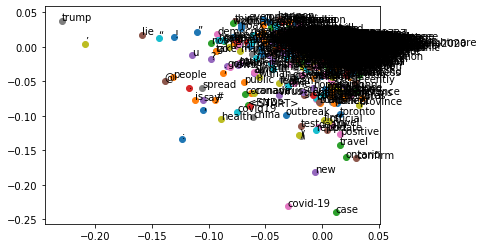

In [21]:
words = [key for key in cm.vocabulary.keys()]

for i, word in enumerate(words):
    
    #if re.match('^co[rv]', word):
    
        x = df['Comp 1'][i]
        y = df['Comp 2'][i]

        plt.scatter(x, y)
        plt.text(x, y, word)

In [22]:
# set word embeddings for text classification
ica = FastICA(n_components = 150)

In [23]:
embeddings = ica.fit_transform(X_std)
embeddings

array([[ 6.00191625e-04,  5.97452916e-03,  8.64786915e-02, ...,
         3.72667698e-03,  1.27456717e-02,  1.06854545e-02],
       [-5.91934288e-04,  1.01559523e-04, -1.67187088e-02, ...,
        -1.08933842e-02,  6.09694548e-03, -8.40743408e-03],
       [-2.01573416e-02,  1.13325008e-02, -4.55023515e-04, ...,
        -2.92303574e-02,  7.50267910e-04,  3.02886554e-02],
       ...,
       [ 1.95427627e-02, -4.61574479e-03,  1.43659312e-01, ...,
        -2.76639442e-02,  4.35716132e-04, -1.06231332e-02],
       [ 1.81873986e-02, -5.57545536e-03, -1.05245016e-02, ...,
        -2.76678721e-02,  1.10239074e-02, -1.19945923e-02],
       [ 5.12144110e-03, -1.52549442e-03, -2.19627386e-03, ...,
         2.03519911e-03, -1.13138415e-03,  3.34601179e-03]])

# Clean text

In [24]:
# clean text - all lowercase & remove stopwords
def clean_text(str_list):
    
    clean_list = []
    
    for text in str_list:
            
        words = word_tokenize(text)

        clean_words = []
        for word in words:
            if word.lower() not in set(stopwords.words('english')):
                clean_words.append(word.lower())
        words = clean_words

        clean_text = ' '.join(clean_words)
        clean_list.append(clean_text)
        
    return clean_list

In [25]:
# run on all tweets
tweets['clean_tweet'] = clean_text(tweets['Tweet'])

In [26]:
# pull out target
y = tweets['Is_Unreliable']

# Derive text vectors from word embeddings

In [27]:
def get_text_vectors(word_embeddings, word_index_dict, text_list):
    for k in range(len(text_list)):
        text = text_list[k]
        text_vec = np.zeros(word_embeddings.shape[1])
        words = word_tokenize(text)
        
        for i in range(len(words)):
            word = words[i]
            if word in word_index_dict:
                word_embed_vec = word_embeddings[word_index_dict[word],:]
                if i == 0:
                    text_matrix = word_embed_vec
                else:
                    text_matrix = np.vstack((text_matrix, word_embed_vec))
                    
        for j in range(len(text_vec)):
            text_vec[j] = text_matrix[:,j].mean()
            
        if k == 0:
            full_matrix = text_vec
        else:
            full_matrix = np.vstack((full_matrix, text_vec))
            
    return full_matrix

In [28]:
X = get_text_vectors(embeddings, cm.vocabulary, tweets['clean_tweet'])

In [29]:
X.shape

(560, 150)

In [30]:
X

array([[ 0.00483513,  0.01106674,  0.03213402, ..., -0.00343397,
        -0.00376895, -0.00978126],
       [-0.0055358 ,  0.0134082 ,  0.07559886, ...,  0.00680922,
        -0.01203508, -0.00589112],
       [-0.00136704,  0.00279167,  0.0007365 , ...,  0.00996737,
        -0.01173808, -0.00634402],
       ...,
       [-0.01658334, -0.01137447,  0.01816877, ..., -0.01019782,
        -0.00375379, -0.0132693 ],
       [-0.00538546,  0.01188388,  0.0022694 , ...,  0.00845571,
        -0.00361018, -0.00260635],
       [ 0.00336443,  0.0151076 ,  0.00812183, ...,  0.00813986,
        -0.00551284,  0.00179793]])

# Classification - nested CV

In [31]:
from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

In [32]:
# create pipeline
pipe = Pipeline([
    ('classify', SVC())
])

In [33]:
# SVC hyperparams to optimize
kernel = ['rbf', 'linear', 'poly', 'sigmoid']
C = [0.001, 0.01, 0.1, 1, 10]
# set up parameter grid
params = {
    'classify__kernel': kernel,
    'classify__C': C
}

In [34]:
# Set CV scheme for inner and outer loops
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 1)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 1)

# Set up GridSearch for inner loop
grid_SVC = GridSearchCV(pipe, params, cv = inner_cv)
#grid_SVC.fit(X, y)

# Nested CV scores
scores = cross_validate(grid_SVC,
                        X = X,
                        y = y,
                        cv = outer_cv,
                        scoring = ['roc_auc', 'accuracy', 'f1', 'precision', 'recall'],
                        return_estimator = True)
auc = scores['test_roc_auc']
accuracy = scores['test_accuracy']
f1 = scores['test_f1']
precision = scores['test_precision']
recall = scores['test_recall']
estimators = scores['estimator']

In [35]:
auc.mean()

0.9348871019685102

In [36]:
accuracy.mean()

0.8714285714285716

In [37]:
f1.mean()

0.8756053510175427

In [38]:
precision.mean()

0.8464566947573193

In [39]:
recall.mean()

0.9086650949407418

In [40]:
for i in estimators:
    print(i.best_params_)
    print('\n')

{'classify__C': 1, 'classify__kernel': 'rbf'}


{'classify__C': 1, 'classify__kernel': 'rbf'}


{'classify__C': 1, 'classify__kernel': 'rbf'}


{'classify__C': 10, 'classify__kernel': 'linear'}


{'classify__C': 1, 'classify__kernel': 'rbf'}


